Load the Shakespeare Text

We'll load the Shakespeare data into memory. If you don't have a text file of Shakespeare, you can download it from here or use a built-in dataset.
Place the text file in the same directory as the notebook.

In [2]:
import tensorflow as tf
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [3]:
import tensorflow as tf

# List all physical devices
physical_devices = tf.config.list_physical_devices('GPU')

print("Available GPUs:", physical_devices)

# Check if any GPU is detected
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU detected and configured:", physical_devices[0])
else:
    print("No GPU detected.")


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU detected and configured: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


Tokenization of Text

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

# Display the total number of unique words
total_words = len(tokenizer.word_index) + 1
print(f'Total words: {total_words}')


Total words: 12633


In [8]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'to': 3,
 'i': 4,
 'of': 5,
 'you': 6,
 'my': 7,
 'a': 8,
 'that': 9,
 'in': 10,
 'is': 11,
 'not': 12,
 'for': 13,
 'with': 14,
 'me': 15,
 'it': 16,
 'be': 17,
 'your': 18,
 'his': 19,
 'but': 20,
 'this': 21,
 'he': 22,
 'have': 23,
 'as': 24,
 'thou': 25,
 'him': 26,
 'so': 27,
 'what': 28,
 'thy': 29,
 'will': 30,
 'by': 31,
 'no': 32,
 'all': 33,
 'king': 34,
 'we': 35,
 'shall': 36,
 'her': 37,
 'if': 38,
 'our': 39,
 'are': 40,
 'do': 41,
 'thee': 42,
 'lord': 43,
 'now': 44,
 'on': 45,
 'good': 46,
 'from': 47,
 'come': 48,
 'sir': 49,
 'or': 50,
 'which': 51,
 'more': 52,
 'then': 53,
 'at': 54,
 'o': 55,
 'would': 56,
 'was': 57,
 'they': 58,
 'how': 59,
 'well': 60,
 'here': 61,
 'she': 62,
 'than': 63,
 'their': 64,
 'them': 65,
 'duke': 66,
 'am': 67,
 'hath': 68,
 'say': 69,
 'let': 70,
 'when': 71,
 'one': 72,
 "i'll": 73,
 'go': 74,
 'love': 75,
 'were': 76,
 'may': 77,
 'us': 78,
 'make': 79,
 'like': 80,
 'upon': 81,
 'yet': 82,
 'richard': 83,

Create Input Sequence

In [9]:
# Create input sequences
input_sequences = []
for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Example of an input sequence
print(input_sequences[:5])


[[88, 269], [139, 35], [139, 35, 969], [139, 35, 969, 143], [139, 35, 969, 143, 668]]


Padding and Sequencing

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Pad sequences and create input/output
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Split into input and output
X = input_sequences[:,:-1]
y = input_sequences[:,-1]

# One-hot encode the output labels
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

# Print the shape of X and y
print(f'Input shape: {X.shape}')
print(f'Output shape: {y.shape}')


Input shape: (171312, 15)
Output shape: (171312, 12633)


RNN Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Model creation
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 64)            808512    
                                                                 
 lstm (LSTM)                 (None, 15, 150)           129000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               100400    
                                                                 
 dense (Dense)               (None, 12633)             1275933   
                                                                 
Total params: 2,313,845
Trainable params: 2,313,845
Non-trainable params: 0
_________________________________________________________________


Train Model

In [56]:
# Set a limit on the vocabulary size
vocab_size_limit = 5000
tokenizer = Tokenizer(num_words=vocab_size_limit)
tokenizer.fit_on_texts([text])

total_words = vocab_size_limit


In [11]:
# Limit sequence length
max_sequence_len = min(max([len(seq) for seq in input_sequences]), 10)


In [12]:
max_sequence_len

10

In [18]:
# Generator function to yield batches
def data_generator(X, y, batch_size):
    num_batches = len(X) // batch_size
    while True:
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            yield X[start:end], y[start:end]

# Train the model with a smaller batch size
batch_size = 128
steps_per_epoch = len(X) // batch_size

history = model.fit(
    data_generator(X, y, batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=100
)

Epoch 1/100
1338/1338 [==============================] - 45s 34ms/step - loss: 6.8138 - accuracy: 0.0353
Epoch 2/100
1302/1338 [============================>.] - ETA: 1s - loss: 6.4384 - accuracy: 0.0513

KeyboardInterrupt: 

In [63]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [64]:
y.shape

(171312, 12633)

Saving Model

In [60]:
import pickle

# Save the model
model.save('shakespeare_rnn_model.h5')

# Save the history
with open('shakespeare_rnn_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


Loading Model

In [11]:
from tensorflow.keras.models import load_model
import pickle

# Load the model
model = load_model('shakespeare_rnn_model.h5')

# Load the history
with open('shakespeare_rnn_history.pkl', 'rb') as file_pi:
    history = pickle.load(file_pi)

# Print history to verify
print(history)

{'loss': [6.959868907928467, 6.4992218017578125, 6.24368953704834, 5.994563579559326, 5.8102192878723145, 5.662965297698975, 5.531857013702393, 5.424130439758301, 5.321738243103027, 5.217729568481445, 5.126590251922607, 5.035015106201172, 4.951894760131836, 4.873672962188721, 4.810822010040283, 4.749529838562012, 4.67952299118042, 4.620975971221924, 4.56265115737915, 4.5013861656188965, 4.4356160163879395, 4.378120422363281, 4.32040548324585, 4.264493465423584, 4.220219135284424, 4.17076301574707, 4.1182756423950195, 4.066110610961914, 4.017970561981201, 3.9708566665649414, 3.9396378993988037, 3.886648654937744, 3.8404159545898438, 3.7957100868225098, 3.752774238586426, 3.7107765674591064, 3.678123712539673, 3.6413421630859375, 3.599871873855591, 3.5606493949890137, 3.526059627532959, 3.4991533756256104, 3.4664227962493896, 3.436906337738037, 3.403465509414673, 3.3711633682250977, 3.3489065170288086, 3.3218955993652344, 3.29890775680542, 3.261976480484009], 'accuracy': [0.0317579880356

Generating new Text

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
def generate_text(seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        #print(np.argmax(predicted))
        predicted_word = tokenizer.index_word[np.argmax(predicted)]
        #print(predicted_word)
        seed_text += " " + predicted_word
    return seed_text

# Example of generating text
seed_text = "Shall i go home"
poem = generate_text(seed_text, 70, max_sequence_len=15) #70
print(poem)

Shall i go home to the air o' the people but come home to the world to all a fever of the house about the king come follow me to the king of all and touch the prophecy and honour of thy state and come to night again and with a woman bound on her gate of that and ours thee fury on the house of twain and so much wrinkled than a grub


In [13]:
# Example of generating text
seed_text = "thou shall not"
poem = generate_text(seed_text, 70, max_sequence_len=15) #70
print(poem)

thou shall not miss't to pick me and the capitol sitting up again and minded by him and he shall have her coral church to have the fire upon thy life and welcome with my head and not so bigger and the sun is punish it a thing ensky'd and rates of the city of him dowry of his business and a man to give rush but to't a fury to the house


Metrics

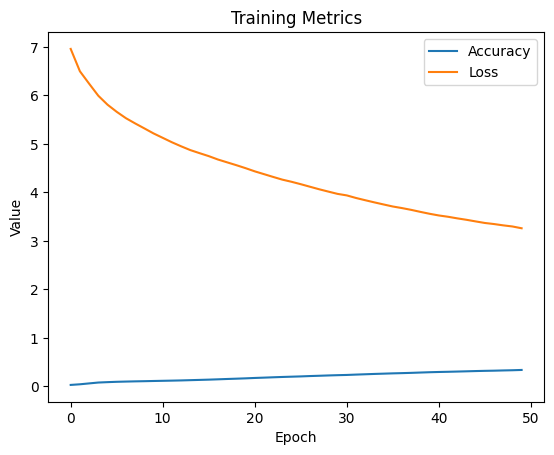

In [76]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.plot(history['accuracy'], label='accuracy')
    plt.plot(history['loss'], label='loss')
    plt.title('Training Metrics')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'Loss'], loc='upper right')
    plt.show()

plot_metrics(history)